In [1]:
# Start
import os
import time
print(("last time run: {}".format(time.strftime("%c"))))
CWD = os.getcwd()
print(("Current working dir: {}".format(CWD)))
print(("Current conda env: {}".format(os.environ['CONDA_PROMPT_MODIFIER'])))

last time run: Thu May  9 22:03:44 2019
Current working dir: /home/bren/Home/projects/CodeForNashville/my-food-desert/data/census
Current conda env: (gis) 


In [2]:
ls

1-create-divvy-station-heatmap.ipynb  FARA2015.xlsx
Businesses/                           Food Desert Colormap.ipynb
Colormaps_0.html                      Food Desert County Colormap.ipynb
Colormaps_1.html                      Housing/
Colormaps_2.html                      Income/
Colormaps_3.html                      SNAP/
Colormaps.ipynb                       tennessee-county-map.gif
data/                                 TIGER2016/
Education/                            TIGER2017/
FARA/


In [3]:
# Style
from IPython.core.display  import HTML
from IPython.core.debugger import set_trace

def css_styling():
    styles = open("/home/bren/Home/python/Jupyter/Jupyter Notebooks/custom.css", "r").read()
    return HTML(styles)
css_styling()

In [4]:
# TOC Setup
import sys
toc_path = "/home/bren/miniconda3/lib/python3.7/site-packages/IPythonTOC-1.2.0-py3.7.egg"
if toc_path not in sys.path:
    sys.path.append(toc_path)
else:
    print("toc_path in sys.path already")

from IPythonTOC import IPythonTOC
toc = IPythonTOC()

toc_path in sys.path already


# Food Desert Colormap

Experiments to produce html file for deployment that is interactive, has multiple layers (census tracts, food sources, community partners) and that has controls. See also http://localhost:8888/notebooks/Home/python/Libraries/GIS/folium/examples/Colormaps.ipynb

<a id="Table_of_Contents"></a> 
## Table of Contents

[Load Data](#Load_Data)

[FARA Record Layout](#FARA_Record_Layout)

[Tiger County Shapefile](#Tiger_County_Shapefile)
* [geopandas heatmap](#geopandas_heatmap)
* [folium heatmap](#folium_heatmap)



In [5]:
# imports
import pandas as pd

import branca.colormap as cm
import geopandas as gpd
import folium
import json
from   json import dumps
from   matplotlib import pyplot as plt, rcParams
import numpy as np
import pandas as pd
import os
import shapefile
import shapely

%matplotlib inline
plt.style.use("ggplot")
rcParams["figure.figsize"] = (14, 7)

import IPython, platform
%reload_ext watermark
print("Python  {}".format(platform.python_version()))
%watermark -v -m -p IPython,matplotlib,numpy,pandas,sys

Python  3.7.1
CPython 3.7.1
IPython 7.2.0

IPython 7.2.0
matplotlib 3.0.2
numpy 1.15.4
pandas 0.24.1
sys 3.7.1 | packaged by conda-forge | (default, Feb 18 2019, 01:42:00) 
[GCC 7.3.0]

compiler   : GCC 7.3.0
system     : Linux
release    : 4.9.0-8-amd64
machine    : x86_64
processor  : 
CPU cores  : 8
interpreter: 64bit


In [6]:
#pd.set_option(""display.height"", 10)
#pd.set_option(""display.max_rows"", 20)
pd.set_option("display.max_colwidth", 500)
pd.set_option("display.expand_frame_repr", True)
pd.set_option("display.width", 1000)

<a id='Load_Data'></a>
## Load Data


[Table of Contents](#Table_of_Contents)

In [7]:
DATA_PATH = os.path.join('./FARA',
                            'Food_Access_Research_Atlas_Data_Variables.csv')
assert os.path.isfile(DATA_PATH)
fara_variables_df = pd.read_csv(DATA_PATH)
fara_variables_df.set_index('Field', inplace=True)

# can lookup variable in dataframe thus:
def fara_field(name):
    print('\n{}: {}'.format(name, fara_variables_df.loc[name].values[0]))
fara_field('lakids1')



lakids1: Low access, children age 0-17 at 1 mile, number


In [8]:
# load data
DATA_PATH_TN = os.path.join('/home/bren/Home/projects/CodeForNashville',
                            'food-desert/data/census/FARA',
                            'Food_Access_Research_Atlas_Data_TN.csv')
if os.path.isfile(DATA_PATH_TN):
    fara_tn_df = pd.read_csv(DATA_PATH_TN)
else:
    DATA_PATH = os.path.join('/home/bren/Home/projects/food-desert/census/data/FARA',
                            'Food_Access_Research_Atlas_Data_TN.csv')
    fara_df = pd.read_csv(DATA_PATH)
    fara_tn_df = fara_df[fara_df.State == 'TN']
    fara_tn_df.to_csv(DATA_PATH_TN, index=False)    
    try:
        del fara_df
    except:
        pass


In [9]:
counties = set(
    [
 'Williamson',
 'Wilson',
 'Robertson',
 'Rutherford',
 'Macon',
 'Sumner',
 'Trousdale',
 'Smith',
 'DeKalb',
 'Cannon',
 'Cheatham',
 'Coffee',
 'Davidson',
 'Bedford',
 'Marshall',
 'Maury',
 'Lewis',
 'Hickman',
 'Dickson',
 'Montgomery',
 'Moore',
    ]
    )
        
# 'Houston',
# 'Humphreys',
# 'Perry',
# 'Stewart',


In [10]:
# select counties to plot
fara_tn_counties_df = fara_tn_df[fara_tn_df.County.apply(lambda x: x in counties)]
len(fara_tn_counties_df.County.unique()) == len(counties)

True

<a id='FARA_Record_Layout'></a>
## FARA Record Layout


[Table of Contents](#Table_of_Contents)

In [11]:
DATA_PATH = os.path.join('./FARA',
                            'Food_Access_Research_Atlas_Data_Variables.csv')
assert os.path.isfile(DATA_PATH)
fara_variables_df = pd.read_csv(DATA_PATH)
fara_variables_df.set_index('Field', inplace=True)

# can lookup variable in dataframe thus:
def fara_field(name):
    print('\n{}: {}'.format(name, fara_variables_df.loc[name].values[0]))
fara_field('lakids1')



lakids1: Low access, children age 0-17 at 1 mile, number


In [12]:
# here are all fieldnames
print(sorted(fara_variables_df.index))


['CensusTract', 'County', 'GroupQuartersFlag', 'HUNVFlag', 'LA1and10', 'LA1and20', 'LATracts1', 'LATracts10', 'LATracts20', 'LATractsVehicle_20', 'LATracts_half', 'LAhalfand10', 'LILATracts_1And10', 'LILATracts_1And20', 'LILATracts_Vehicle', 'LILATracts_halfAnd10', 'LowIncomeTracts', 'NUMGQTRS', 'OHU2010', 'PCTGQTRS', 'POP2010', 'Rural', 'State', 'UATYP10', 'Urban', 'lahunv1', 'lahunv10', 'lahunv10share', 'lahunv1share', 'lahunv20', 'lahunv20share', 'lahunvhalf', 'lahunvhalfshare', 'lakids1', 'lakids10', 'lakids10share', 'lakids1share', 'lakids20', 'lakids20share', 'lakidshalf', 'lakidshalfshare', 'lalowi1', 'lalowi10', 'lalowi10share', 'lalowi1share', 'lalowi20', 'lalowi20share', 'lalowihalf', 'lalowihalfshare', 'lapop1', 'lapop10', 'lapop10share', 'lapop1share', 'lapop20', 'lapop20share', 'lapophalf', 'lapophalfshare', 'laseniors1', 'laseniors10', 'laseniors10share', 'laseniors1share', 'laseniors20', 'laseniors20share', 'laseniorshalf', 'laseniorshalfshare']


<a id='Tiger_County_Shapefile'></a>
## Tiger County Shapefile


[Table of Contents](#Table_of_Contents)

<a id='geopandas_heatmap'></a>
## geopandas heatmap


[Table of Contents](#Table_of_Contents)

In [13]:
%%time

# load county shapefiles into geopandas geodataframe
sf = gpd.GeoDataFrame.from_file("TIGER2016/county/tl_2016_us_county.shp")
print(sf.columns, '\n')

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD', 'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'], dtype='object') 

CPU times: user 1.03 s, sys: 104 ms, total: 1.13 s
Wall time: 1.07 s


In [14]:
# we only want tennessee, aka statefp 47
tn = sf.STATEFP == '47'
sf = sf[tn]


In [15]:
# subset of tennessee counties we will plot
counties = set(
    [
 'Williamson',
 'Wilson',
 'Robertson',
 'Rutherford',
 'Macon',
 'Sumner',
 'Trousdale',
 'Smith',
 'DeKalb',
 'Cannon',
 'Cheatham',
 'Coffee',
 'Davidson',
 'Bedford',
 'Marshall',
 'Maury',
 'Lewis',
 'Hickman',
 'Dickson',
 'Montgomery',
 'Moore',
    ]
    )
        

In [16]:
%matplotlib inline

# control format and size of plot
plt.style.use("ggplot")
rcParams["figure.figsize"] = (40, 14)


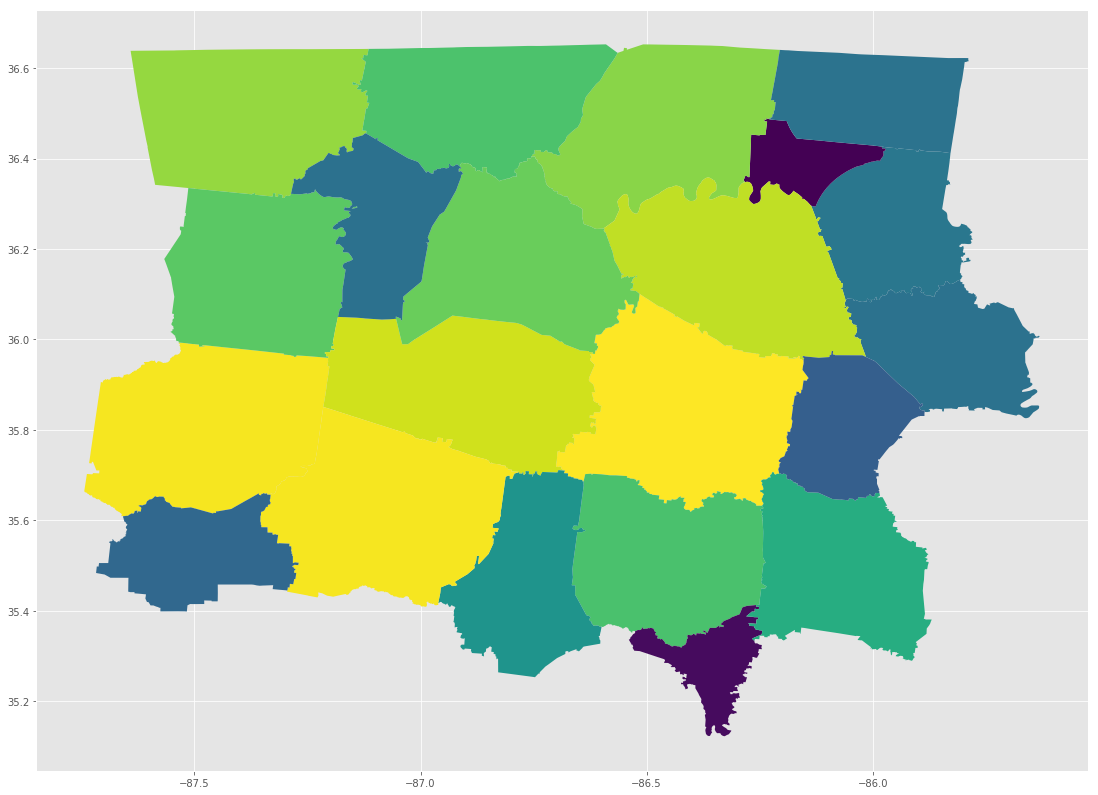

In [17]:
county_sf = sf[sf.NAME.apply(lambda x: x in counties)]
county_sf.plot(column='ALAND');

In [18]:
# pull one_hot tracts (only 0 or 1 values) and convert to percent of tracts in county
One_Hot_cols = 'Urban LILATracts_1And10 LILATracts_halfAnd10 LILATracts_1And20 LILATracts_Vehicle HUNVFlag \
LowIncomeTracts'.split(' ') + ['LA1and10', 'LAhalfand10', 'LA1and20', 'LATracts_half', 'LATracts1', 'LATracts10',\
                               'LATracts20', 'LATractsVehicle_20']

gb = fara_tn_counties_df['CensusTract County'.split(' ') + One_Hot_cols].groupby('County')

# calculate percentages - transposing to match shape then transposing result back to original
One_Hot_counties_df =  (gb[One_Hot_cols].sum().T / gb.apply(lambda x: len(x)).values).T

# NAME ends up as index - need NAME as column for heatmap lookup later
One_Hot_counties_df['NAME'] = One_Hot_counties_df.index
One_Hot_counties_df.head()


,Urban,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,LILATracts_Vehicle,HUNVFlag,LowIncomeTracts,LA1and10,LAhalfand10,LA1and20,LATracts_half,LATracts1,LATracts10,LATracts20,LATractsVehicle_20,NAME
County,,,,,,,,,,,,,,,,
Bedford,0.333333,0.222222,0.222222,0.222222,0.222222,0.333333,0.333333,0.444444,0.444444,0.333333,1.000000,1.000000,0.111111,0.0,0.333333,Bedford
Cannon,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.0,0.333333,Cannon
Cheatham,0.222222,0.000000,0.111111,0.000000,0.000000,0.000000,0.333333,0.111111,0.222222,0.111111,1.000000,0.888889,0.000000,0.0,0.000000,Cheatham
Coffee,0.333333,0.083333,0.083333,0.083333,0.083333,0.083333,0.250000,0.416667,0.416667,0.333333,1.000000,1.000000,0.083333,0.0,0.083333,Coffee
Davidson,0.931677,0.192547,0.453416,0.192547,0.186335,0.217391,0.490683,0.465839,0.888199,0.465839,0.956522,0.534161,0.000000,0.0,0.217391,Davidson


In [19]:
# merge county shapefile with one-hot percentages
fara_county_df = pd.merge(left=county_sf, right=One_Hot_counties_df, on='NAME')
fara_county_df.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD', 'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry', 'Urban', 'LILATracts_1And10', 'LILATracts_halfAnd10', 'LILATracts_1And20', 'LILATracts_Vehicle', 'HUNVFlag', 'LowIncomeTracts', 'LA1and10', 'LAhalfand10', 'LA1and20', 'LATracts_half', 'LATracts1', 'LATracts10', 'LATracts20', 'LATractsVehicle_20'], dtype='object')

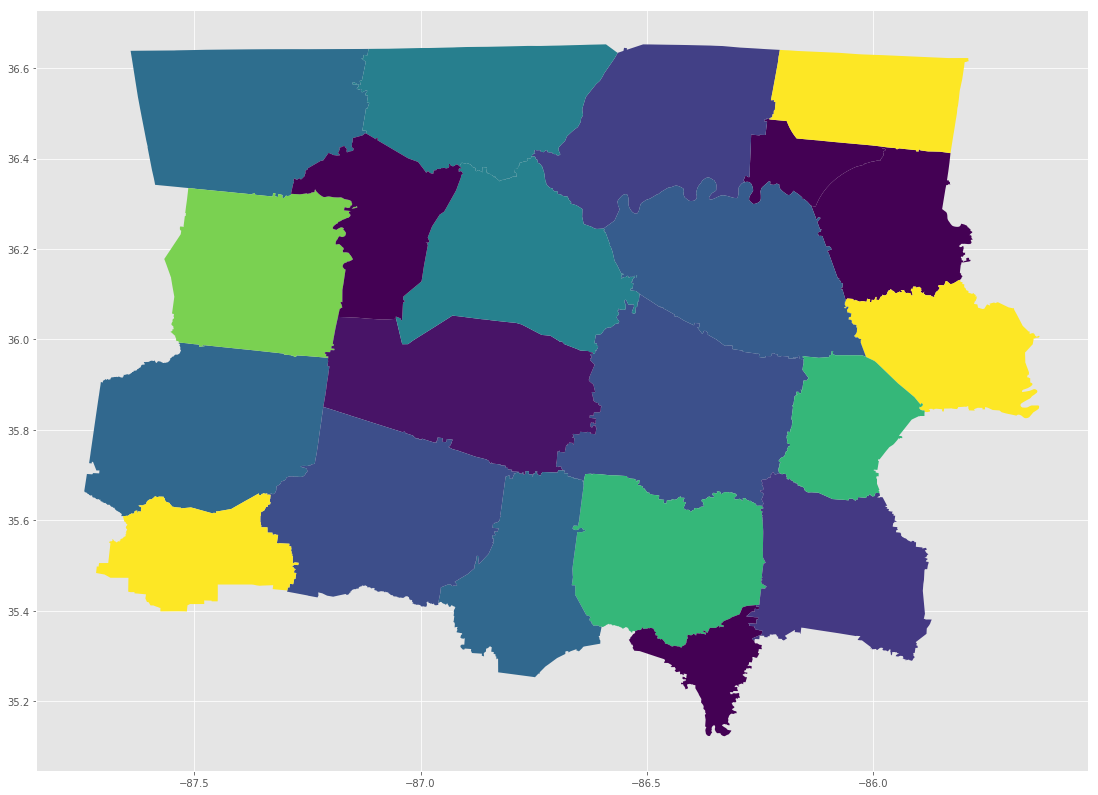

In [20]:
fara_county_df.plot(column='LATractsVehicle_20');

<a id='folium_heatmap'></a>
## folium heatmap


[Table of Contents](#Table_of_Contents)

In [21]:
area = county_sf.set_index('COUNTYFP')['ALAND AWATER'.split(' ')]
area.loc['101', 'ALAND']


730608072

In [22]:
#from cm import linear
from branca.colormap import linear

colormap = linear.YlGn_09.scale(
    area.ALAND.min(),
    area.ALAND.max())

print('mean color code:', colormap(area.ALAND.mean()))

colormap

mean color code: #49af61


In [23]:
area

,ALAND,AWATER
COUNTYFP,,
149,1604151408,12142906
159,814016768,28694080
169,296143573,5960720
165,1371067660,35857194
003,1226719728,2980817
041,788283759,63786567
081,1586324704,373710
127,334684869,3093435
111,795498357,246690


In [24]:
fara_county_df.set_index('NAME', inplace=True)
fara_county_df['NAME'] = fara_county_df.index


In [27]:
# a function to create the heatmap
def heat_map(heat_var, gdf=fara_county_df, lookup_col='NAME'):
    import branca.colormap
    linear = branca.colormap.LinearColormap(
        ['green', 'yellow', 'red'],
        vmin=fara_county_df[heat_var].min(), vmax=fara_county_df[heat_var].max()
    )


    # we'll use the geopandas geodataframe to create a leaflet.js heatmap
    m = folium.Map([35.9, -86.7816], tiles='OpenStreetMap', zoom_start=9)

    folium.GeoJson(
        gdf,
        style_function=lambda feature: {
            'fillColor': linear(gdf.loc[feature['properties'][lookup_col],
                                           heat_var]),
            'color': 'black',
            'weight': 1,
            'dashArray': '5, 5',
            'fillOpacity': 0.5,
        }
    ).add_to(m)

    mm = (gdf[heat_var].min(), gdf[heat_var].max())
    colormap = linear
    colormap.caption = heat_var
    m.add_child(colormap)

    return m


In [28]:
# select variable that determines "heat"
heat_var = 'LowIncomeTracts'

heat_map(heat_var)


In [29]:
fara_county_df.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAMELSAD', 'LSAD', 'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry', 'Urban', 'LILATracts_1And10', 'LILATracts_halfAnd10', 'LILATracts_1And20', 'LILATracts_Vehicle', 'HUNVFlag', 'LowIncomeTracts', 'LA1and10', 'LAhalfand10', 'LA1and20', 'LATracts_half', 'LATracts1', 'LATracts10', 'LATracts20', 'LATractsVehicle_20', 'NAME'], dtype='object')

In [30]:
# select variable that determines "heat"
heat_var = 'LILATracts_Vehicle'

heat_map(heat_var)